## Library

In [1]:
# ====================================================
# Library
# ====================================================

import os
import copy
import time
from random import randrange, randint
import cv2
cv2.setNumThreads(0) # solution to OpenCV multithread incompatible with pytorch multithread num workers in DataLoader


import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline
#%matplotlib notebook

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from torch.optim import SGD, Adam, AdamW
from torch.optim import lr_scheduler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'working with {device}')
print(torch.cuda.is_available())

working with cuda
True


## CFG

In [2]:
class CFG():
    num_epochs = 100
    batch_size = 512
    learning_rate = 1e-3

## Datasets, transformations and Dataloaders

In [3]:
# Transformations

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.1307], std=[0.3081])
])

transform_fashionmnist = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.2900], std=[0.3541])
])

In [4]:
# Download the training and test datasets

MNIST = datasets.MNIST(root='Autoencoders_data', train=True, download=True, 
                       transform=transform_mnist)

train_mnist, val_mnist = torch.utils.data.random_split(MNIST, [50000, 10000])

test_fasmnist = datasets.FashionMNIST(root='Autoencoders_data', train=False, download=True, 
                                      transform=transform_fashionmnist)

print('MNIST train/val',len(train_mnist), len(val_mnist))
print('Fashion MNIST',len(test_fasmnist))

MNIST train/val 50000 10000
Fashion MNIST 10000


In [5]:
#Prepare data loaders
train_loader = DataLoader(train_mnist, batch_size=CFG.batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_mnist, batch_size=CFG.batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_fasmnist, batch_size=CFG.batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0))) 


#Obtain one batch of training images
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

print(images.shape, type(images), labels.shape, images.mean(), images.min(), images.max())

(512, 1, 28, 28) <class 'numpy.ndarray'> torch.Size([512]) 0.1298914 0.0 1.0


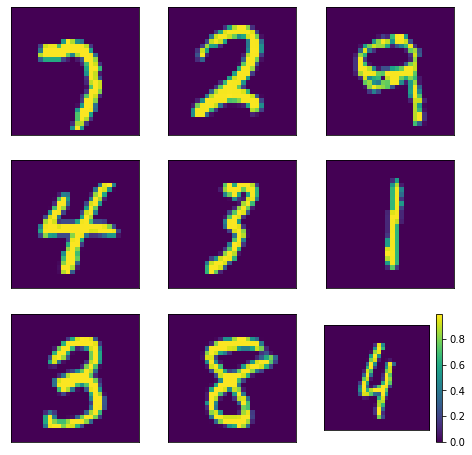

In [7]:
#Plot the images
fig = plt.figure(figsize=(8, 8))

# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    
plt.colorbar()


## Model

In [8]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self):
        
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, (3,3), stride=1, padding=1),  # (N,16,28,28)
            nn.ReLU(True),
            nn.MaxPool2d((2,2), stride=2, padding=0),  # (N,16,14,14)
            nn.Conv2d(16, 8, (3,3), stride=1, padding=1),  # (N,8,14,14)
            nn.ReLU(True),
            nn.MaxPool2d((2,2), stride=2, padding=0),  # (N,8,7,7)
            nn.Conv2d(8, 8, (3,3), stride=1, padding=1), # (N,8,7,7)
            nn.MaxPool2d((2,2), stride=2, padding=1), # (N,8,4,4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, (3,3), stride=2, padding=2),  #(N,16,5,5)
            nn.Conv2d(16, 16, (3,3), stride=1, padding=1), #(N,16,5,5)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, (5,5), stride=3, padding=1),  #(N,8,15,15)
            nn.Conv2d(8, 8, (3,3), stride=1, padding=1), #(N,8,15,15)
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, (2,2), stride=2, padding=1),  #(N,1,28,28)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

### Initialize model, optimizer, BCE loss

In [9]:
model = ConvAutoencoder()

model.to(device)

optimizer = Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=1e-5)

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

## Train

epoch [1/100], train loss:0.5510, val loss:0.3007
epoch [2/100], train loss:0.2486, val loss:0.2271
epoch [3/100], train loss:0.2082, val loss:0.1920
epoch [4/100], train loss:0.1832, val loss:0.1755
epoch [5/100], train loss:0.1691, val loss:0.1639
epoch [6/100], train loss:0.1594, val loss:0.1561
epoch [7/100], train loss:0.1525, val loss:0.1504
epoch [8/100], train loss:0.1470, val loss:0.1448
epoch [9/100], train loss:0.1424, val loss:0.1407
epoch [10/100], train loss:0.1385, val loss:0.1370
epoch [11/100], train loss:0.1353, val loss:0.1350
epoch [12/100], train loss:0.1327, val loss:0.1320
epoch [13/100], train loss:0.1303, val loss:0.1295
epoch [14/100], train loss:0.1282, val loss:0.1275
epoch [15/100], train loss:0.1262, val loss:0.1258
epoch [16/100], train loss:0.1245, val loss:0.1242
epoch [17/100], train loss:0.1229, val loss:0.1226
epoch [18/100], train loss:0.1214, val loss:0.1210
epoch [19/100], train loss:0.1200, val loss:0.1198
epoch [20/100], train loss:0.1188, val l

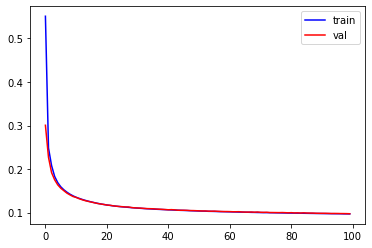

In [10]:
loss_train_history, loss_val_history = [], []
for epoch in range(CFG.num_epochs):   
    epoch_train_loss, epoch_val_loss = 0, 0
    
    model.train()
    
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
    model.eval()
    
    for data in val_loader:
        img, _ = data
        img = img.to(device)
        # ===================forward=====================
        with torch.no_grad():
            
            output = model(img)
            loss = criterion(output, img)       
        
        epoch_val_loss += loss.item()
        
    
    # compute the epoch training/val loss
    epoch_train_loss = epoch_train_loss / len(train_loader)
    epoch_val_loss = epoch_val_loss / len(val_loader)
    
    loss_train_history.append(epoch_train_loss)
    loss_val_history.append(epoch_val_loss)
    
    # display the epoch loss
    print(f'epoch [{epoch+1}/{CFG.num_epochs}], train loss:{epoch_train_loss:.4f}, val loss:{epoch_val_loss:.4f}')

    
fig, ax = plt.subplots()

ax.plot(np.arange(len(loss_train_history)), loss_train_history, c='b', label='train')
ax.plot(np.arange(len(loss_val_history)), loss_val_history, c='r', label='val')

plt.legend()
plt.show()

## Show some autoencoded examples on the val (mnist) and test (fashion mnist) sets

#### Note that the mnist photos will be reconstructed pretty well (since we are training the autoencoder on such dataset), while the fashion mnist photos will be reconstructed less well. The BCE loss for mnist images will be lower.

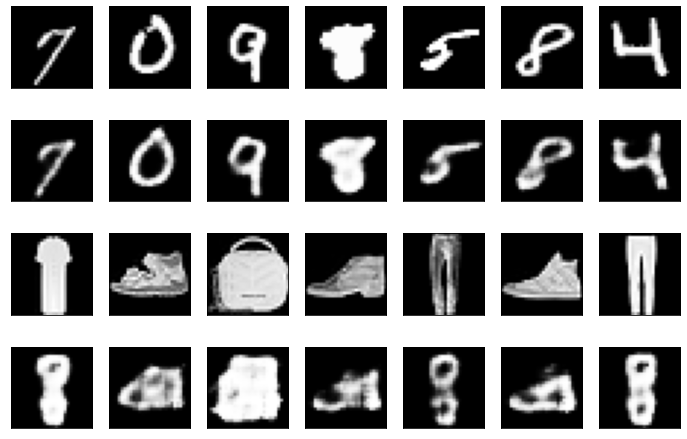

In [11]:
val_iter = iter(val_loader)
test_iter = iter(test_loader)
# get a batch
val_images, _ = val_iter.next() #(512, 1, 28, 28)
test_images, _ = test_iter.next() #(512, 1, 28, 28)

# move to GPU
val_images = val_images.to(device)
test_images = test_images.to(device)

# forward and get autoencoded image
with torch.no_grad(): 
    rec_val_images = model(val_images)
    rec_test_images = model(test_images)

# move all images back to cpu and covert to numpy for plot
val_images = val_images.cpu().numpy()
test_images = test_images.cpu().numpy()

rec_val_images = rec_val_images.cpu().numpy()
rec_test_images = rec_test_images.cpu().numpy()


#------------------------------------------------------
#-------------- PLOT ----------------------------------
#------------------------------------------------------

fig, axs = plt.subplots(nrows=4, ncols=7, figsize=(12,8))
for j in range(7):
    n = randrange(CFG.batch_size) # random sample the batch
    axs[0,j].imshow(val_images[n,0], cmap='gray') #(28,28)
    axs[1,j].imshow(rec_val_images[n,0], cmap='gray')
    
    axs[2,j].imshow(test_images[n,0], cmap='gray') #(28,28)
    axs[3,j].imshow(rec_test_images[n,0], cmap='gray')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # remove the ticks and numbers for x and y axis
plt.show()

## Scan MNIST (val) and FashionMNIST (test) datasets and calculate BCE loss of individual images

In [12]:
val_loader = DataLoader(val_mnist, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_fasmnist, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

mnist_bce_losses = []
fashionmnist_bce_losses = []

with torch.no_grad():
    
    print('... Scanning mnist dataset and calculating BCE loss')
    for i, (val_images, _) in enumerate(val_loader):      
        val_images = val_images.to(device)
        rec_val_images = model(val_images)
        loss = criterion(rec_val_images, val_images)
        
        mnist_bce_losses.append(loss.item())
        
    print('... Scanning fashion mnist dataset and calculating BCE loss')   
    for i, (test_images, _) in enumerate(test_loader):      
        test_images = test_images.to(device)
        rec_test_images = model(test_images)
        loss = criterion(rec_test_images, test_images)
        
        fashionmnist_bce_losses.append(loss.item())
        
print(f'Val elements {len(mnist_bce_losses)} mean val loss {np.mean(mnist_bce_losses)}')
print(f'test  elements {len(fashionmnist_bce_losses)} mean test loss {np.mean(fashionmnist_bce_losses)}')

... Scanning mnist dataset and calculating BCE loss
... Scanning fashion mnist dataset and calculating BCE loss
Val elements 10000 mean val loss 0.09751953430622816
test  elements 10000 mean test loss 0.5981844718337059


## Plot the values of BCE loss. The two distributions can be well separated. We have a tool to separate the two types of images (e.g. for outlier detections)

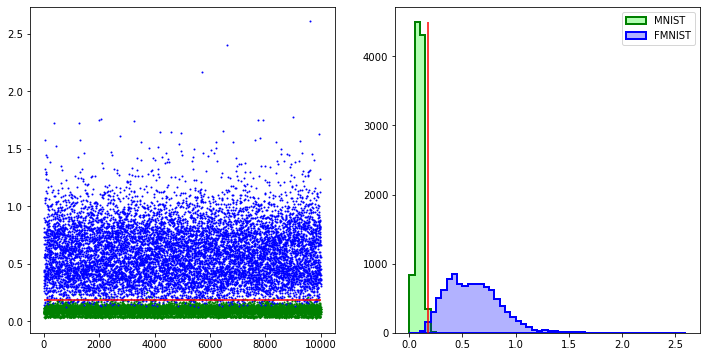

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].scatter(np.arange(len(mnist_bce_losses)), mnist_bce_losses, s=1, c='g', label='MNIST')
ax[0].scatter(np.arange(len(fashionmnist_bce_losses)), fashionmnist_bce_losses, s=1, c='b', label='FMNIST')

ax[0].hlines(0.185, 0, len(mnist_bce_losses), colors='red', linestyles='solid')

             
bins = np.arange(0, max(fashionmnist_bce_losses), 0.05) 

bY_mnist, bX_mnist, _ = ax[1].hist(mnist_bce_losses, bins=bins, label='MNIST', align='mid', histtype='stepfilled', ec='g', lw=2, fc=(0, 1, 0, 0.3))
bY_fmnist, bX_fmnist, _ = ax[1].hist(fashionmnist_bce_losses, bins=bins, label='FMNIST', align='mid', histtype='stepfilled', ec='b', lw=2, fc=(0, 0, 1, 0.3))

ax[1].vlines(0.179, 0, np.max(bY_mnist), colors='red', linestyles='solid')

plt.legend()
plt.show()

In [14]:
best_acc = 0
best_th = 0
for th in np.arange(0.14, 0.3, 0.001):
    selected_mnist = sum(i < th for i in mnist_bce_losses) 
    selected_fmnist = sum(i >= th for i in fashionmnist_bce_losses)
    acc = ( selected_mnist + selected_fmnist )/( len(mnist_bce_losses) + len(fashionmnist_bce_losses) )
    if acc>best_acc:
        best_acc = acc
        best_th = th
    print(f'{th:.3f} {acc:.4f}')

print()
print('Best threshold for separation', best_th, 'Best acc', best_acc)


0.140 0.9668
0.141 0.9682
0.142 0.9696
0.143 0.9712
0.144 0.9725
0.145 0.9739
0.146 0.9758
0.147 0.9769
0.148 0.9781
0.149 0.9794
0.150 0.9802
0.151 0.9812
0.152 0.9820
0.153 0.9831
0.154 0.9840
0.155 0.9850
0.156 0.9859
0.157 0.9863
0.158 0.9867
0.159 0.9872
0.160 0.9880
0.161 0.9884
0.162 0.9888
0.163 0.9891
0.164 0.9898
0.165 0.9903
0.166 0.9905
0.167 0.9908
0.168 0.9912
0.169 0.9914
0.170 0.9917
0.171 0.9918
0.172 0.9916
0.173 0.9915
0.174 0.9915
0.175 0.9916
0.176 0.9918
0.177 0.9919
0.178 0.9921
0.179 0.9921
0.180 0.9922
0.181 0.9921
0.182 0.9919
0.183 0.9919
0.184 0.9918
0.185 0.9916
0.186 0.9915
0.187 0.9915
0.188 0.9915
0.189 0.9915
0.190 0.9918
0.191 0.9917
0.192 0.9917
0.193 0.9917
0.194 0.9915
0.195 0.9913
0.196 0.9909
0.197 0.9906
0.198 0.9903
0.199 0.9900
0.200 0.9898
0.201 0.9894
0.202 0.9892
0.203 0.9889
0.204 0.9888
0.205 0.9886
0.206 0.9883
0.207 0.9881
0.208 0.9879
0.209 0.9878
0.210 0.9875
0.211 0.9872
0.212 0.9870
0.213 0.9866
0.214 0.9863
0.215 0.9861
0.216 0.9859